In [ ]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import matplotlib.lines as mlines

## Plotting Functions

In [ ]:
def plot_FI_inverse(x, a, theta):
    """
    Plot the inverse of the activation function
    """
    f, ax = plt.subplots()
    ax.plot(x, F_inv(x, a=a, theta=theta))
    ax.set(xlabel="$x$", ylabel="$F^{-1}(x)$")


def plot_FI_EI(x, FI_exc, FI_inh):
    """
    Plot the activation fuction for the E and I populations
    """
    plt.figure()
    plt.plot(x, FI_exc, 'b', label='E population')
    plt.plot(x, FI_inh, 'r', label='I population')
    plt.legend(loc='lower right')
    plt.xlabel('x (a.u.)')
    plt.ylabel('F(x)')
    plt.show()


def my_test_plot(t, rE1, rI1, rE2, rI2):
    """
    Plot activities of E and I population for two different initial conditions
    """

    plt.figure()
    ax1 = plt.subplot(211)
    ax1.plot(pars['range_t'], rE1, 'b', label='E population')
    ax1.plot(pars['range_t'], rI1, 'r', label='I population')
    ax1.set_ylabel('Activity')
    ax1.legend(loc='best')

    ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
    ax2.plot(pars['range_t'], rE2, 'b', label='E population')
    ax2.plot(pars['range_t'], rI2, 'r', label='I population')
    ax2.set_xlabel('t (ms)')
    ax2.set_ylabel('Activity')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()


## Helper functions

In [ ]:
def default_pars(**kwargs):
    """
    Define the parameters of the dynamical system
    """
    pars = {}

    # Excitatory parameters
    pars['tau_E'] = 1.     # Timescale of the E population [ms]
    pars['a_E'] = 1.2      # Gain of the E population
    pars['theta_E'] = 2.8  # Threshold of the E population

    # Inhibitory parameters
    pars['tau_I'] = 2.0    # Timescale of the I population [ms]
    pars['a_I'] = 1.0      # Gain of the I population
    pars['theta_I'] = 4.0  # Threshold of the I population

    # Connection strength
    pars['wEE'] = 9.   # E to E
    pars['wEI'] = 4.   # I to E
    pars['wIE'] = 13.  # E to I
    pars['wII'] = 11.  # I to I

    # External input
    pars['I_ext_E'] = 0.
    pars['I_ext_I'] = 0.

    # simulation parameters
    pars['T'] = 50.        # Total duration of simulation [ms]
    pars['dt'] = .1        # Simulation time step [ms]
    pars['rE_init'] = 0.2  # Initial value of E
    pars['rI_init'] = 0.2  # Initial value of I

    # External parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    # Vector of discretized time points [ms]
    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

    return pars


def F(x, a, theta):
    """
    Population activation function, F-I curve

    Args:
        x     : the population input
        a     : the gain of the function
        theta : the threshold of the function

    Returns:
        f     : the population activation response f(x) for input x
    """

    f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

    return f


def dF(x, a, theta):
    """
    Derivative of the population activation function.

    Args:
        x     : the population input
        a     : the gain of the function
        theta : the threshold of the function

    Returns:
        dFdx  :  Derivative of the population activation function.
    """

    dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

    return dFdx


def F_inv(x, a, theta):
    """
    Inverse of the population activation function.
    Args:
        x         : the population input
        a         : the gain of the function
        theta     : the threshold of the function

    Returns:
        F_inverse : value of the inverse function
    """

    # Calculate Finverse (ln(x) can be calculated as np.log(x))
    F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta

    return F_inverse


def EIderivs(rE, rI,tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
             tau_I, a_I, theta_I, wIE, wII, I_ext_I,
             **other_pars):
    """
    Time derivatives for E/I variables (dE/dt, dI/dt).
    """

    drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E
    drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

    return drEdt, drIdt

def simulate_wc(tau_E, a_E, theta_E, tau_I, a_I, theta_I,
                wEE, wEI, wIE, wII, I_ext_E, I_ext_I,
                rE_init, rI_init, dt, range_t, **other_pars):
    """
    Simulate the Wilson-Cowan equations

    Args:
        Parameters of the Wilson-Cowan model

    Returns:
        rE, rI (arrays) : Activity of excitatory and inhibitory populations
    """
    # Initialize activity arrays
    Lt = range_t.size
    rE = np.append(rE_init, np.zeros(Lt - 1))
    rI = np.append(rI_init, np.zeros(Lt - 1))
    I_ext_E = I_ext_E * np.ones(Lt)
    I_ext_I = I_ext_I * np.ones(Lt)

    # Simulate the Wilson-Cowan equations
    for k in range(Lt - 1):

        # Calculate the derivative of the E population
        drE = dt / tau_E * (-rE[k] + F(wEE * rE[k] - wEI * rI[k] + I_ext_E[k],
                                   a_E, theta_E))

        # Calculate the derivative of the I population
        drI = dt / tau_I * (-rI[k] + F(wIE * rE[k] - wII * rI[k] + I_ext_I[k],
                                   a_I, theta_I))

        # Update using Euler's method
        rE[k + 1] = rE[k] + drE
        rI[k + 1] = rI[k] + drI

    return rE, rI

task 1

In [ ]:
pars = default_pars()

nullclines

Text(0, 0.5, '$I$')

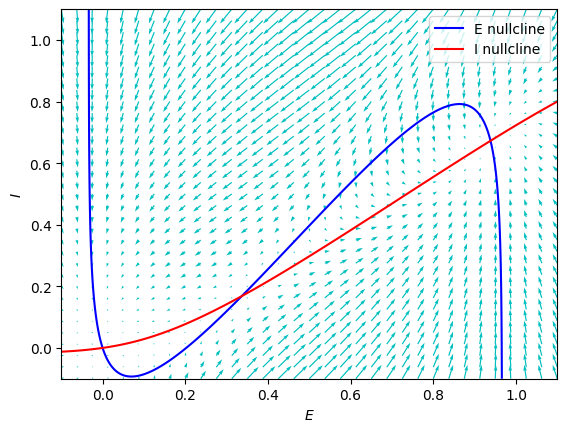

In [ ]:
#create meshgrid of points
delta = 0.0025
x = np.arange(-0.1, 1.1, delta)
y = np.arange(-0.1, 1.1, delta)
X, Y = np.meshgrid(x, y)
#evaluate derivatives
Z1,Z2 = EIderivs(X,Y,**default_pars())
#plot nullclines
fig, ax = plt.subplots()
CS1 = ax.contour(x, y, Z1,levels=[0],colors='b') #using contour to plot the 2 nullclines
CS2 = ax.contour(x,y,Z2,levels=[0],colors='r')
n_skip=15
plt.quiver(X[::n_skip, ::n_skip], Y[::n_skip, ::n_skip],
             Z1[::n_skip, ::n_skip], Z2[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=12., facecolor='c') #vector field
#plotting labels
line1 = mlines.Line2D([], [], color='blue', linestyle='solid', label='E nullcline')
line2 = mlines.Line2D([], [], color='red', linestyle='solid', label='I nullcline')
plt.legend(handles=[line1, line2], loc='upper right')
plt.xlabel(r'$E$')
plt.ylabel(r'$I$')

find critical points

In [ ]:
#function to find roots of (derivative with default parameters)
def fun(x):

  return EIderivs(x[0],x[1],**default_pars())

r1=opt.root(fun,[0.1,0.1])
r2=opt.root(fun,[0.3,0.2])
r3=opt.root(fun,[0.9,0.6])

In [ ]:
r1['x'] #first crit point coords

array([0., 0.])

In [ ]:
r2['x'] #second

array([0.33685241, 0.16841968])

In [ ]:
r3['x'] #third

array([0.93843047, 0.67248104])

task 2

In [ ]:
def jacmatrix(critE,critI,tau_E, a_E, theta_E, wEE, wEI, I_ext_E,tau_I, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  #jacobian matrix
  jaco = np.zeros((2, 2))
  jaco[0, 0] = (wEE* dF(wEE*critE - wEI* critI + I_ext_E,a_E, theta_E)-1)/tau_E
  jaco[0, 1] = (-wEI* dF(wEE* critE - wEI* critI + I_ext_E,a_E, theta_E))/tau_E
  jaco[1, 0] = (wIE* dF(wIE* critE - wII* critI + I_ext_I,a_I, theta_I))/tau_I
  jaco[1, 1] = (-1 - wII * dF(wIE * critE - wII* critI + I_ext_I,a_I, theta_I))/tau_I
  return jaco

#find eigenvalues
def eigen(critE,critI):
  jaco=jacmatrix(critE,critI,**default_pars())
  return np.linalg.eig(jaco)[0]

In [ ]:
eigen(0,0) #first critical point stable

array([-0.62338386+0.13110957j, -0.62338386-0.13110957j])

In [ ]:
eigen(3.369e-01,1.684e-01) #second unstable

array([ 1.05741471, -0.87291568])

In [ ]:
eigen(9.384e-01,6.725e-01) #third stable

array([-0.95947936, -1.42221108])

confirmation for task 2

In [ ]:
line1 = mlines.Line2D([], [], color='blue', linestyle='solid', label='E nullcline')
line2 = mlines.Line2D([], [], color='red', linestyle='solid', label='I nullcline')
#to plot the legend

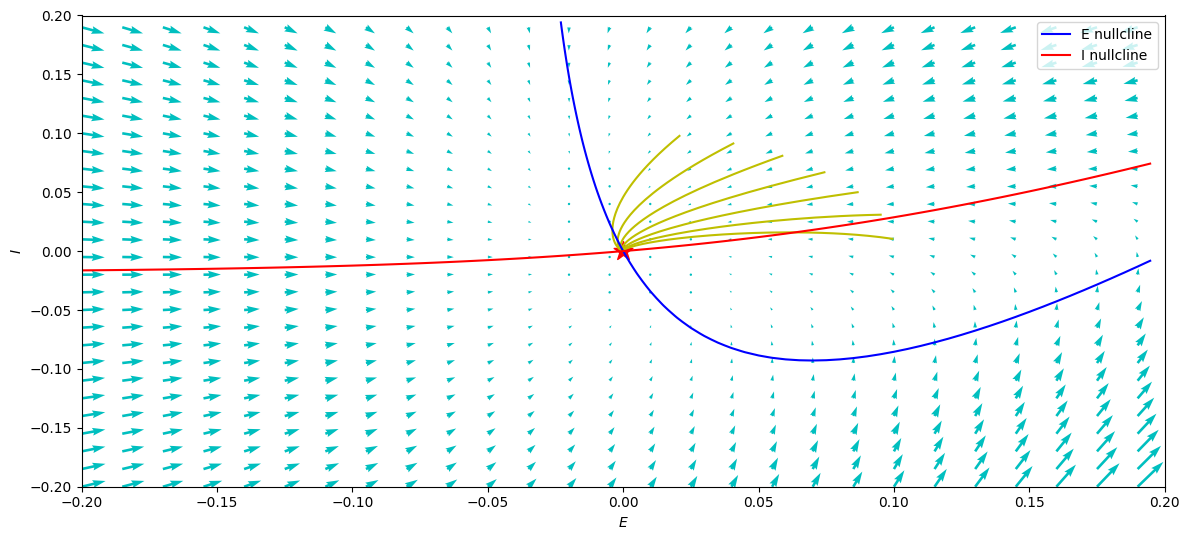

In [ ]:
def criteval(angles=4,centerx=0,centery=0,vector_field=False):
  plt.figure(figsize=(12, 5.5))
#plot activities
  angles=np.arange(0, 2*np.pi, 2*np.pi/angles)
  plt.xlim(centerx-0.2,centerx+0.2) #limit plotting to near the critical point
  plt.ylim(centery-0.2,centery+0.2)
  for angle in angles:
    Estart=centerx+0.1*np.sin(angle)
    Istart=centery+0.1*np.cos(angle) #choose the point to start with in a circle with center the critical point
    if Istart>0 and Estart>0:
       rE, rI = simulate_wc(**default_pars(rE_init=Estart, rI_init=Istart)) #simulate
       plt.plot(rE, rI,'y')

# plot the E, I nullclines
  delta = 0.005
  x = np.arange(centerx-0.2, centerx+0.2, delta)
  y = np.arange(centery-0.2, centery+0.2, delta)
  X, Y = np.meshgrid(x, y) #create meshgrid of points near critical point
  Z1,Z2 = EIderivs(X,Y,**default_pars(rE_init=.33, rI_init=.2))
  CS1 = plt.contour(x, y, Z1,levels=[0],colors='b') #plotting nullclines
  CS2 = plt.contour(x,y,Z2,levels=[0],colors='r')
  plt.scatter(centerx, centery, marker='*', s=200, color='r') #critical point plot
  #vector field
  if vector_field:
    n_skip=3
    plt.quiver(X[::n_skip, ::n_skip], Y[::n_skip, ::n_skip],
             Z1[::n_skip, ::n_skip], Z2[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=20., facecolor='c')

  #legends plot
  plt.legend(handles=[line1, line2], loc='upper right')
  plt.xlabel(r'$E$')
  plt.ylabel(r'$I$')
  plt.tight_layout()
  plt.show()

criteval(30,0,0,vector_field=True) #should attract

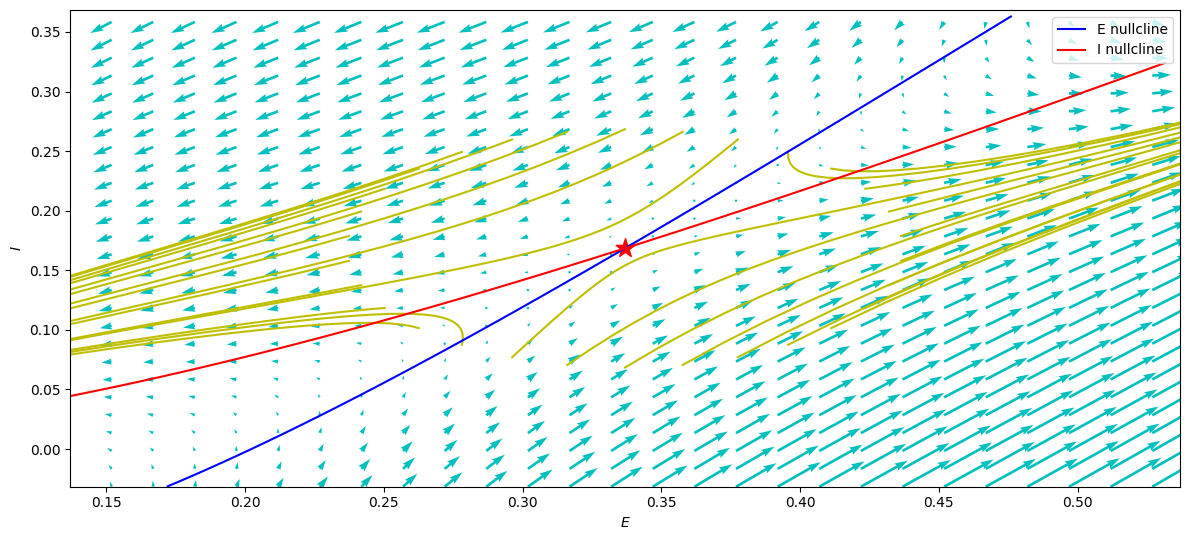

In [ ]:
criteval(30,3.369e-01,1.684e-01,vector_field=True) #should repulse

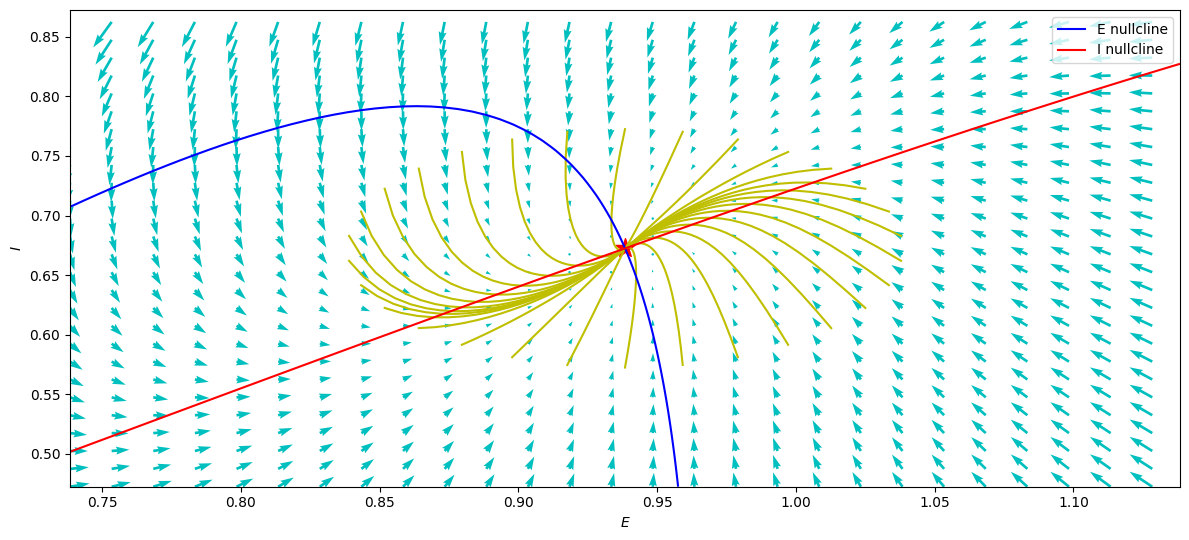

In [ ]:
criteval(30,9.384e-01,6.725e-01,vector_field=True) #should attract

task 6

In [ ]:
pars = default_pars(T=400.,dt = .05 )
#c1 = 6.4, c2 = 4.8, c3 = 6.0 and c4 = 1.2
pars['wEE'] = 6.4   # E to E
pars['wEI'] = 4.8   # I to E
pars['wIE'] = 6  # E to I
pars['wII'] = 1.2  # I to I
#E(0) = 0.32 and I(0) = 0.15.
pars['rE_init'] = 0.32  # Initial value of E
pars['rI_init'] = 0.15 # Initial value of I 15

line3 = mlines.Line2D([], [], color='yellow', linestyle='solid', label='trajectory')

In [ ]:
delta = 0.05
x = np.arange(-0.10, 1.1, delta)
y = np.arange(-0.1, 1.1, delta)
X, Y = np.meshgrid(x, y)
#meshgrid

def plot_iext(iext=0.72):
  pars['I_ext_E'] = iext
  pars['rE_init'] = 0.32
  pars['rI_init'] = 0.15
  plt.figure(figsize=(12, 5.5))
  plt.subplot(122)
  #simulate and plot trajectories
  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E population')
  plt.plot(pars['range_t'], rI, 'r', label='I population')
  plt.legend(loc='best')

  plt.subplot(121)
  # plot the E, I nullclines

  Z1,Z2 = EIderivs(X,Y,**pars)
  CS1 = plt.contour(x, y, Z1,levels=[0],colors='b')
  CS2 = plt.contour(x,y,Z2,levels=[0],colors='r')
  plt.scatter(pars['rE_init'], pars['rI_init'], marker='*', s=200, color='y')
  #vector field
  n_skip=2
  plt.quiver(X[::n_skip, ::n_skip], Y[::n_skip, ::n_skip],
             Z1[::n_skip, ::n_skip], Z2[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=5., facecolor='c')
  #labels
  plt.plot(rE, rI, 'y')
  plt.legend(handles=[line1, line2 ,line3], loc='upper right')
  plt.xlabel(r'$E$')
  plt.ylabel(r'$I$')
  plt.tight_layout()
  plt.show()

In [ ]:
_ = widgets.interact(plot_iext,iext = (0.001,1.2,0.001))

interactive(children=(FloatSlider(value=0.72, description='iext', max=1.2, min=0.001, step=0.001), Output()), …

In [ ]:

def plot_start(Estart,Istart):
  pars['I_ext_E'] = 0.76
  pars['rE_init']=Estart
  pars['rI_init']=Istart
  plt.figure(figsize=(12, 5.5))
  plt.subplot(122)
  #plot activities

  rE, rI = simulate_wc(**pars)
  plt.plot(pars['range_t'], rE, 'b', label='E population')
  plt.plot(pars['range_t'], rI, 'r', label='I population')
  plt.legend(loc='best')

  plt.subplot(121)
  # plot the E, I nullclines

  Z1,Z2 = EIderivs(X,Y,**pars)
  CS1 = plt.contour(x, y, Z1,levels=[0],colors='b')
  CS2 = plt.contour(x,y,Z2,levels=[0],colors='r')

  #vector field
  n_skip=1
  plt.quiver(X[::n_skip, ::n_skip], Y[::n_skip, ::n_skip],
             Z1[::n_skip, ::n_skip], Z2[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=7., facecolor='c')
  plt.plot(rE, rI, 'y')
  plt.scatter(rE[0], rI[0], marker='*', s=200, color='y')
  plt.legend(handles=[line1, line2 ,line3], loc='upper right')
  plt.xlabel(r'$E$')
  plt.ylabel(r'$I$')
  plt.tight_layout()
  plt.show()
_ = widgets.interact(plot_start,Estart=(0.001,1,0.001),Istart = (0.001,1,0.001))

interactive(children=(FloatSlider(value=0.5, description='Estart', max=1.0, min=0.001, step=0.001), FloatSlide…